In [1]:
from script.model_localization import pyramid, sliding_window, iou_bbox, non_maximum_supperssion, visualize_bbox
from script.model_classification import SVMObjectClassifier
from sklearn.model_selection import train_test_split
from script.dataset import load_vehicle_dataset, load_traffic_signboard_dataset
from script.feature_source import FeatureExtracter
from script.training import training_model
from sklearn.metrics import classification_report
from script.augmentation import generate_images
import matplotlib.pyplot as plt
from collections import Counter
from script.slider import Slider
import pandas as pd
import numpy as np
import argparse
import time
import cv2
import os
import random

random.seed(42)

# Original

Number of objects:  1074
Classes:  ['stop', 'speedlimit', 'crosswalk']


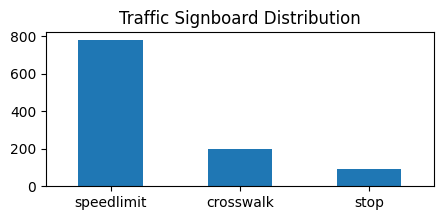

In [2]:
# Load dữ liệu từ tập dữ liệu biển báo giao thông
X, y = load_traffic_signboard_dataset()
# Tạo Series và đếm số lần xuất hiện của các giá trị
count_series = pd.Series(y).value_counts()
# Vẽ biểu đồ thanh
ax = count_series.plot(kind='bar', title='Traffic Signboard Distribution', figsize=(5, 2))
# Chỉnh nhãn trục x thành viết ngang
plt.xticks(rotation=0)
# Hiển thị biểu đồ
plt.show()

In [3]:
sourcer_params = {               # hls, hsv, yuv, ycrcb 
  'spatial_size': (32, 32),            # (16, 16), (32, 32), (64, 64)
  'orientations': 9,        # 6 - 12
  'pixels_per_cell': 8,               # 8, 16
  'cells_per_block': 2,                # 1, 2
  'transform_sqrt': True,
  'block_norm': 'L2',
  'hog_visualize': False
}
save_path = './save_model'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
acc_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
precision_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
recall_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
f1_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])

C_list = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

In [4]:
for kernel in kernel_list:
    for C in C_list:
        feature_extracter = FeatureExtracter(**sourcer_params)
        model = SVMObjectClassifier(kernel=kernel, C=C)
        model.set_feature_extracter(feature_extracter)
        #print('Training...')
        model.train(X_train, y_train)
        #print('Evaluating...')
        y_pred_labels = model.predict(X_test)[1]
        report = classification_report(y_test, y_pred_labels, labels=list(set(y_test)), output_dict=True)
        acc_report.loc[kernel, str(C)] = report['accuracy']
        precision_report.loc[kernel, str(C)] = report['weighted avg']['precision']
        recall_report.loc[kernel, str(C)] = report['weighted avg']['recall']
        f1_report.loc[kernel, str(C)] = report['weighted avg']['f1-score']

In [5]:
acc_report

,0.1,0.3,0.5,0.7,0.9
linear,0.990712,0.990712,0.990712,0.990712,0.990712
poly,0.990712,0.990712,0.990712,0.990712,0.990712
rbf,0.987616,0.987616,0.987616,0.987616,0.987616
sigmoid,0.987616,0.98452,0.98452,0.98452,0.978328


In [6]:
precision_report

,0.1,0.3,0.5,0.7,0.9
linear,0.990836,0.990836,0.990836,0.990836,0.990836
poly,0.990674,0.990674,0.990674,0.990674,0.990674
rbf,0.988028,0.988028,0.988028,0.988028,0.987851
sigmoid,0.987546,0.984546,0.984546,0.984861,0.978282


In [7]:
recall_report

,0.1,0.3,0.5,0.7,0.9
linear,0.990712,0.990712,0.990712,0.990712,0.990712
poly,0.990712,0.990712,0.990712,0.990712,0.990712
rbf,0.987616,0.987616,0.987616,0.987616,0.987616
sigmoid,0.987616,0.98452,0.98452,0.98452,0.978328


In [8]:
f1_report

,0.1,0.3,0.5,0.7,0.9
linear,0.990529,0.990529,0.990529,0.990529,0.990529
poly,0.990645,0.990645,0.990645,0.990645,0.990645
rbf,0.987334,0.987334,0.987334,0.987334,0.987289
sigmoid,0.987448,0.984341,0.984341,0.984208,0.978027


In [9]:
feature_extracter = FeatureExtracter(**sourcer_params)
model = SVMObjectClassifier(kernel='rbf', C=0.5)
model.set_feature_extracter(feature_extracter)
print('Training...')
model.train(X_train, y_train)
print('Evaluating...')
model.evaluate(X_test, y_test)
print('Saving model...')
model.save(save_path)

Training...
Evaluating...
Accuracy on validation dataset: 0.98
Saving model...


# Resampling

Number of objects:  1074
Classes:  ['speedlimit', 'stop', 'crosswalk']


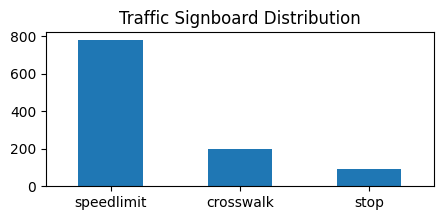

In [12]:
# Load dữ liệu từ tập dữ liệu biển báo giao thông
X, y = load_traffic_signboard_dataset()
# Tạo Series và đếm số lần xuất hiện của các giá trị
count_series = pd.Series(y).value_counts()
# Vẽ biểu đồ thanh
ax = count_series.plot(kind='bar', title='Traffic Signboard Distribution', figsize=(5, 2))
# Chỉnh nhãn trục x thành viết ngang
plt.xticks(rotation=0)
# Hiển thị biểu đồ
plt.show()

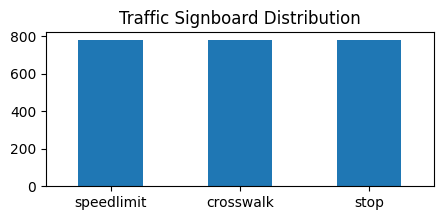

In [13]:
# Tạo danh sách các ảnh biển báo "crosswalk"
X_crosswalk = [X[index] for index in range(len(y)) if y[index] == "crosswalk"]

# Tạo danh sách các ảnh biển báo "stop"
X_stop = [X[index] for index in range(len(y)) if y[index] == "stop"]

# Tính chiều dài mong muốn cho danh sách các ảnh "crosswalk" và "stop"
crosswalk_desired_length = count_series.max() - len(X_crosswalk)
stop_desired_length = count_series.max() - len(X_stop)

# Tạo ảnh tăng cường cho danh sách ảnh "crosswalk" và "stop"
X_crosswalk_sub = generate_images(X_crosswalk, crosswalk_desired_length, augmented=False, plot=False)
X_stop_sub = generate_images(X_stop, stop_desired_length, augmented=False, plot=False)

# Tạo nhãn mới cho các ảnh tăng cường
y_crosswalk_sub = ["crosswalk"] * len(X_crosswalk_sub)
y_stop_sub = ["stop"] * len(X_stop_sub)

# Kết hợp danh sách ảnh gốc và ảnh tăng cường
X = X + X_crosswalk_sub + X_stop_sub
y = y + y_crosswalk_sub + y_stop_sub

# Tạo Series và đếm số lần xuất hiện của các giá trị
count_series = pd.Series(y).value_counts()

# Vẽ biểu đồ thanh
ax = count_series.plot(kind='bar', title='Traffic Signboard Distribution', figsize=(5, 2))

# Chỉnh nhãn trục x thành viết ngang
plt.xticks(rotation=0)

# Hiển thị biểu đồ
plt.show()

In [14]:
sourcer_params = {               # hls, hsv, yuv, ycrcb 
  'spatial_size': (32, 32),            # (16, 16), (32, 32), (64, 64)
  'orientations': 9,        # 6 - 12
  'pixels_per_cell': 8,               # 8, 16
  'cells_per_block': 2,                # 1, 2
  'transform_sqrt': True,
  'block_norm': 'L2',
  'hog_visualize': False
}
save_path = './save_model'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
acc_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
precision_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
recall_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
f1_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])

C_list = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

In [15]:
for kernel in kernel_list:
    for C in C_list:
        feature_extracter = FeatureExtracter(**sourcer_params)
        model = SVMObjectClassifier(kernel=kernel, C=C)
        model.set_feature_extracter(feature_extracter)
        #print('Training...')
        model.train(X_train, y_train)
        #print('Evaluating...')
        y_pred_labels = model.predict(X_test)[1]
        report = classification_report(y_test, y_pred_labels, labels=list(set(y_test)), output_dict=True)
        acc_report.loc[kernel, str(C)] = report['accuracy']
        precision_report.loc[kernel, str(C)] = report['weighted avg']['precision']
        recall_report.loc[kernel, str(C)] = report['weighted avg']['recall']
        f1_report.loc[kernel, str(C)] = report['weighted avg']['f1-score']

In [16]:
acc_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998582,0.998582,0.998582,0.998582,0.998582
poly,0.997163,0.998582,1.0,1.0,1.0
rbf,0.991489,0.997163,0.997163,0.997163,0.997163
sigmoid,0.997163,0.998582,0.998582,0.998582,0.998582


In [17]:
precision_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998588,0.998588,0.998588,0.998588,0.998588
poly,0.997187,0.998588,1.0,1.0,1.0
rbf,0.991562,0.997188,0.997188,0.997188,0.997186
sigmoid,0.997163,0.998588,0.998588,0.998588,0.998588


In [18]:
recall_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998582,0.998582,0.998582,0.998582,0.998582
poly,0.997163,0.998582,1.0,1.0,1.0
rbf,0.991489,0.997163,0.997163,0.997163,0.997163
sigmoid,0.997163,0.998582,0.998582,0.998582,0.998582


In [19]:
f1_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998582,0.998582,0.998582,0.998582,0.998582
poly,0.997163,0.998582,1.0,1.0,1.0
rbf,0.991478,0.997163,0.997163,0.997163,0.997163
sigmoid,0.997163,0.998582,0.998582,0.998582,0.998582


In [21]:
feature_extracter = FeatureExtracter(**sourcer_params)
model = SVMObjectClassifier(kernel='rbf', C=0.5)
model.set_feature_extracter(feature_extracter)
print('Training...')
model.train(X_train, y_train)
print('Evaluating...')
model.evaluate(X_test, y_test)
print('Saving model...')
model.save(save_path)

Training...
Evaluating...
Accuracy on validation dataset: 0.99
Saving model...


# With Augmentation

Number of objects:  1074
Classes:  ['speedlimit', 'stop', 'crosswalk']


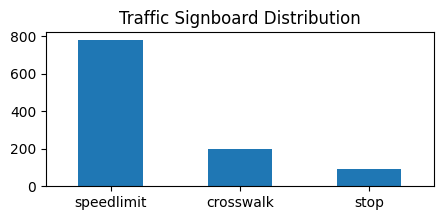

In [22]:
# Load dữ liệu từ tập dữ liệu biển báo giao thông
X, y = load_traffic_signboard_dataset()
# Tạo Series và đếm số lần xuất hiện của các giá trị
count_series = pd.Series(y).value_counts()
# Vẽ biểu đồ thanh
ax = count_series.plot(kind='bar', title='Traffic Signboard Distribution', figsize=(5, 2))
# Chỉnh nhãn trục x thành viết ngang
plt.xticks(rotation=0)
# Hiển thị biểu đồ
plt.show()

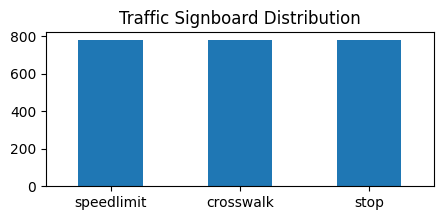

In [23]:
# Tạo danh sách các ảnh biển báo "crosswalk"
X_crosswalk = [X[index] for index in range(len(y)) if y[index] == "crosswalk"]

# Tạo danh sách các ảnh biển báo "stop"
X_stop = [X[index] for index in range(len(y)) if y[index] == "stop"]

# Tính chiều dài mong muốn cho danh sách các ảnh "crosswalk" và "stop"
crosswalk_desired_length = count_series.max() - len(X_crosswalk)
stop_desired_length = count_series.max() - len(X_stop)

# Tạo ảnh tăng cường cho danh sách ảnh "crosswalk" và "stop"
X_crosswalk_augmented = generate_images(X_crosswalk, crosswalk_desired_length, plot=False)
X_stop_augmented = generate_images(X_stop, stop_desired_length, plot=False)

# Tạo nhãn mới cho các ảnh tăng cường
y_crosswalk_augmented = ["crosswalk"] * len(X_crosswalk_augmented)
y_stop_augmented = ["stop"] * len(X_stop_augmented)

# Kết hợp danh sách ảnh gốc và ảnh tăng cường
X = X + X_crosswalk_augmented + X_stop_augmented
y = y + y_crosswalk_augmented + y_stop_augmented

# Tạo Series và đếm số lần xuất hiện của các giá trị
count_series = pd.Series(y).value_counts()

# Vẽ biểu đồ thanh
ax = count_series.plot(kind='bar', title='Traffic Signboard Distribution', figsize=(5, 2))

# Chỉnh nhãn trục x thành viết ngang
plt.xticks(rotation=0)

# Hiển thị biểu đồ
plt.show()


In [24]:
sourcer_params = {               # hls, hsv, yuv, ycrcb 
  'spatial_size': (32, 32),            # (16, 16), (32, 32), (64, 64)
  'orientations': 9,        # 6 - 12
  'pixels_per_cell': 8,               # 8, 16
  'cells_per_block': 2,                # 1, 2
  'transform_sqrt': True,
  'block_norm': 'L2',
  'hog_visualize': False
}
save_path = './save_model'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
acc_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
precision_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
recall_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])
f1_report = pd.DataFrame(columns=['0.1', '0.3', '0.5', '0.7', '0.9'], index=['linear', 'poly', 'rbf', 'sigmoid'])

C_list = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

In [25]:
for kernel in kernel_list:
    for C in C_list:
        feature_extracter = FeatureExtracter(**sourcer_params)
        model = SVMObjectClassifier(kernel=kernel, C=C)
        model.set_feature_extracter(feature_extracter)
        #print('Training...')
        model.train(X_train, y_train)
        #print('Evaluating...')
        y_pred_labels = model.predict(X_test)[1]
        report = classification_report(y_test, y_pred_labels, labels=list(set(y_test)), output_dict=True)
        acc_report.loc[kernel, str(C)] = report['accuracy']
        precision_report.loc[kernel, str(C)] = report['weighted avg']['precision']
        recall_report.loc[kernel, str(C)] = report['weighted avg']['recall']
        f1_report.loc[kernel, str(C)] = report['weighted avg']['f1-score']

In [26]:
acc_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998582,0.998582,0.998582,0.998582,0.998582
poly,0.992908,0.998582,1.0,1.0,1.0
rbf,0.97305,0.978723,0.980142,0.98156,0.984397
sigmoid,0.995745,0.997163,0.998582,0.998582,0.998582


In [27]:
precision_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998588,0.998588,0.998588,0.998588,0.998588
poly,0.992959,0.998588,1.0,1.0,1.0
rbf,0.973829,0.97955,0.981078,0.982547,0.985109
sigmoid,0.995763,0.997163,0.998588,0.998588,0.998588


In [28]:
recall_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998582,0.998582,0.998582,0.998582,0.998582
poly,0.992908,0.998582,1.0,1.0,1.0
rbf,0.97305,0.978723,0.980142,0.98156,0.984397
sigmoid,0.995745,0.997163,0.998582,0.998582,0.998582


In [29]:
f1_report

,0.1,0.3,0.5,0.7,0.9
linear,0.998582,0.998582,0.998582,0.998582,0.998582
poly,0.992907,0.998582,1.0,1.0,1.0
rbf,0.973125,0.97882,0.980235,0.981665,0.984448
sigmoid,0.995745,0.997163,0.998582,0.998582,0.998582


In [30]:
feature_extracter = FeatureExtracter(**sourcer_params)
model = SVMObjectClassifier(kernel='rbf', C=0.1)
model.set_feature_extracter(feature_extracter)
print('Training...')
model.train(X_train, y_train)
print('Evaluating...')
model.evaluate(X_test, y_test)
print('Saving model...')
model.save(save_path)

Training...
Evaluating...
Accuracy on validation dataset: 0.94
Saving model...
